# Joint Source-Channel Coding using Autoencoders

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* joint compression and error protection of images by auto-encoders
* transmission of pseudo-analog values over an AWGN channel

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cuda


### Import and load MNIST dataset (Preprocessing)

Dataloader are powerful instruments, which help you to prepare your data. E.g. you can shuffle your data, transform data (standardize/normalize), divide it into batches, ...  For more information see https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader <br>

In our case, we just use the dataloader to download the Dataset and preprocess the data on our own.


In [2]:
batch_size_train = 60000      # Samples per Training Batch
batch_size_test = 10000     # just create one large test dataset (MNIST test dataset has 10.000 Samples)

# Get Training and Test Dataset with a Dataloader
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=True, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./files/', train=False, download=True,
  transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])),
  batch_size=batch_size_test, shuffle=True)

# We are only interessted in the data and not in the targets
for idx, (data, targets) in enumerate(train_loader):
    x_train = data[:,0,:,:]

for idx, (data, targets) in enumerate(test_loader):
    x_test = data[:,0,:,:]

image_size = x_train.shape[1]
x_test_flat = torch.reshape(x_test, (x_test.shape[0], image_size*image_size))

Print 8 random images to illustrate the dataset

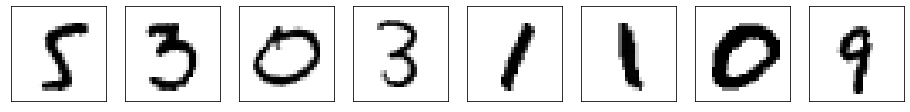

In [5]:
plt.figure(figsize=(16,2))
for k in range(8):
    plt.subplot(1,8,k+1)
    plt.imshow(x_train[np.random.randint(x_train.shape[0])], interpolation='nearest', cmap='binary')
    plt.xticks(())
    plt.yticks(())

### Specify neural network
Transmitter and receiver consist of each 3 hidden layers with ELU activation function

In [6]:
# Network parameters
hidden_encoder_1 = 500
hidden_encoder_2 = 250
hidden_encoder_3 = 100
hidden_encoder = [hidden_encoder_1, hidden_encoder_2, hidden_encoder_3]

hidden_decoder_1 = 100
hidden_decoder_2 = 250
hidden_decoder_3 = 500
hidden_decoder = [hidden_decoder_1, hidden_decoder_2, hidden_decoder_3]

class Autoencoder(nn.Module):
    def __init__(self, hidden_encoder, hidden_decoder, image_size, channel_uses):
        super(Autoencoder, self).__init__()
        # Define Transmitter Layer: Linear function, M input neurons (symbols), 2 output neurons (real and imaginary part)        
        self.We1 = nn.Linear(image_size*image_size, hidden_encoder[0]) 
        self.We2 = nn.Linear(hidden_encoder[0], hidden_encoder[1]) 
        self.We3 = nn.Linear(hidden_encoder[1], hidden_encoder[2]) 
        self.We4 = nn.Linear(hidden_encoder[2], 2*channel_uses) 
        
        # Define Receiver Layer: Linear function, 2 input neurons (real and imaginary part), M output neurons (symbols)
        self.Wd1 = nn.Linear(2*channel_uses,hidden_decoder[0]) 
        self.Wd2 = nn.Linear(hidden_decoder[0], hidden_decoder[1]) 
        self.Wd3 = nn.Linear(hidden_decoder[1], hidden_decoder[2]) 
        self.Wd4 = nn.Linear(hidden_decoder[2], image_size*image_size) 

        # Non-linearity (used in transmitter and receiver)
        self.activation_function = nn.ELU()    
        self.sigmoid = nn.Sigmoid()

    def forward(self, training_data, sigma_n):
        compressed = self.encoder(training_data)
        transmitted = self.channel(compressed, sigma_n)
        reconstructed = self.decoder(transmitted)
        return reconstructed
        
    def encoder(self, batch):
        temp = self.activation_function(self.We1(batch))
        temp = self.activation_function(self.We2(temp))
        temp = self.activation_function(self.We3(temp))
        output = self.activation_function(self.We4(temp))
        return output
    
    def decoder(self, batch):
        temp = self.activation_function(self.Wd1(batch))
        temp = self.activation_function(self.Wd2(temp))
        temp = self.activation_function(self.Wd3(temp))
        output = self.sigmoid(self.Wd4(temp))
        return output
    
    def channel(self, batch, sigma_n):
        # just add noise, nothing else
        norm_factor = torch.sqrt(torch.mean(torch.mul(batch,batch)) * 2 )                            
        modulated = batch / norm_factor 
        output = torch.add(modulated, sigma_n*torch.randn(modulated.size()).to(device))
        return output

In [7]:
batch_size = 250

num_epochs = 15
num_batches = 10

EsN0 = 30
sigma_n = np.sqrt((1/2) * 10**(-EsN0/10))
channel_uses = 5

model = Autoencoder(hidden_encoder, hidden_decoder, image_size, channel_uses)
model.to(device)

# Means squared error loss
loss_fn = nn.MSELoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters())  

Helper function to get a random batch of images from the dataset

In [8]:
def get_batch(x, batch_size):
    idxs = np.random.randint(0, x.shape[0], (batch_size))
    return torch.stack([torch.reshape(x[k], (-1,)) for k in idxs])

### Perform the training

In [9]:
print('Start Training')   # Training loop

for it in range(25000):  # Original paper does 50k iterations  
    mini_batch = torch.Tensor(get_batch(x_train, batch_size)).to(device)
    # Propagate (training) data through the net
    reconstructed = model(mini_batch, sigma_n)
    
    # compute loss
    loss = loss_fn(mini_batch, reconstructed)

    # compute gradients
    loss.backward()

    # Adapt weights
    optimizer.step()

    # reset gradients
    optimizer.zero_grad()
    
    # Evaulation with the test data
    if it % 1000 == 0:
        reconstructed_test = model(x_test_flat.to(device), sigma_n)
        loss_test = torch.mean(torch.square(x_test_flat.to(device) - reconstructed_test))
        print('It %d: Loss %1.5f' % (it, loss_test.detach().cpu().numpy().squeeze()))
    
print('Training finished')

Start Training
It 0: Loss 0.22570
It 1000: Loss 0.01885
It 2000: Loss 0.01480
It 3000: Loss 0.01360
It 4000: Loss 0.01272
It 5000: Loss 0.01238
It 6000: Loss 0.01178
It 7000: Loss 0.01159
It 8000: Loss 0.01137
It 9000: Loss 0.01125
It 10000: Loss 0.01114
It 11000: Loss 0.01120
It 12000: Loss 0.01093
It 13000: Loss 0.01087
It 14000: Loss 0.01085
It 15000: Loss 0.01079
It 16000: Loss 0.01069
It 17000: Loss 0.01070
It 18000: Loss 0.01082
It 19000: Loss 0.01055
It 20000: Loss 0.01061
It 21000: Loss 0.01063
It 22000: Loss 0.01050
It 23000: Loss 0.01057
It 24000: Loss 0.01066
Training finished


### Evaluation

Illustrate 8 images and their reconstruction after transmission over the channel

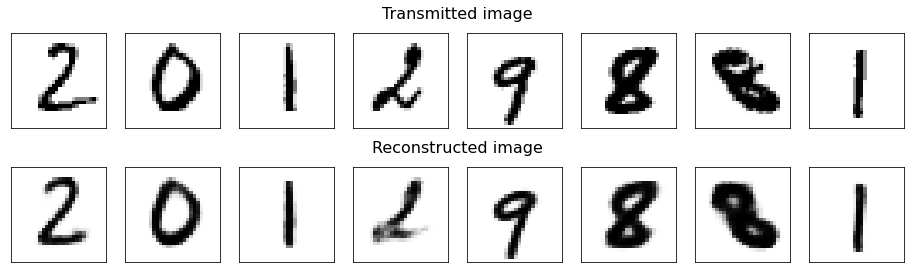

In [10]:
valid_images =  model(x_test_flat.to(device), sigma_n).detach().cpu().numpy()
# show 8 images and their reconstructed versions

fig,big_ax = plt.subplots(2,1,figsize=(16,4.5), sharey=True)        
big_ax[0].set_title("Transmitted image", fontsize=16)
big_ax[1].set_title("Reconstructed image", fontsize=16)

for k in range(2):
    big_ax[k].tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    big_ax[k]._frameon = False
    big_ax[k].set_xticks(())
    big_ax[k].set_yticks(())
            
idx = np.random.randint(x_test.shape[0], size=8)       
r_idx = 1
for k in range(8):
    ax = fig.add_subplot(2,8,r_idx)     
    ax.imshow(np.reshape(x_test_flat.cpu()[idx[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')    
    ax.set_xticks(())
    ax.set_yticks(())
    r_idx += 1
    
for k in range(8):
    ax = fig.add_subplot(2,8,r_idx)    
    ax.imshow(np.reshape(valid_images[idx[k]], (image_size,image_size)), interpolation='nearest', cmap='binary')     
    ax.set_xticks(())
    ax.set_yticks(())
    r_idx +=1 
#plt.savefig('Autoencoder_AWGN_Analog_Esn030.pdf',bbox_inches='tight')

(10000, 10)


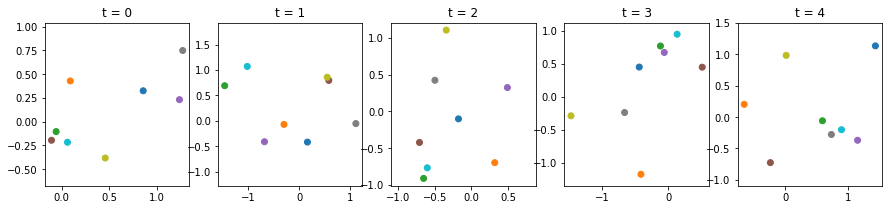

In [11]:
# display received constellations
transmitted = model.channel(model.encoder(x_test_flat.to(device)), sigma_n).detach().cpu().numpy()
print(transmitted.shape)
plt.figure(figsize=(15,3))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.scatter(transmitted[idx,2*k], transmitted[idx,2*k+1],c=range(8),cmap='tab10')
    plt.title('t = %d' % k)
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.axis('equal')
#plt.savefig('Autoencoder_AWGN_Analog_Esn030_scatter8points.pdf',bbox_inches='tight')

(10000, 10)


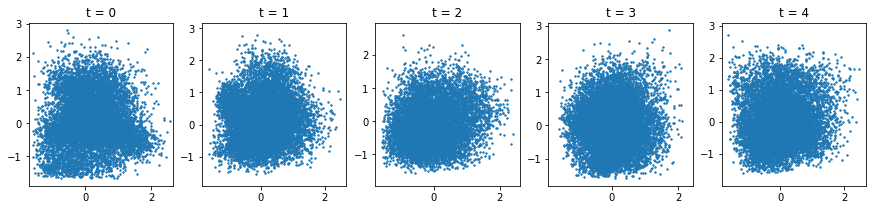

In [12]:
# display received constellations
transmitted = model.channel(model.encoder(x_test_flat.to(device)), sigma_n).detach().cpu().numpy()
print(transmitted.shape)
plt.figure(figsize=(15,3))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.scatter(transmitted[:,2*k], transmitted[:,2*k+1],s=2)
    plt.title('t = %d' % k)
    plt.xlim((-3,3))
    plt.ylim((-3,3))
    plt.axis('equal')
#plt.savefig('Autoencoder_AWGN_Analog_Esn030_scatterallpoints.pdf',bbox_inches='tight')